# Fourwing Generation Acceleration

#### Created by Group B (PYNQ IMAGEINE): cakeforcat, Kandor9178 & sark02    (Github usernames)

Purpose: <br>Submission for University of Strathclyde course: EE315 Further VHDL and FPGA Design <br>

Aim: <br>To accelerate the process of generating strange attractors by passing off computationally challenging sections to the PL area of the device to quickly process them in parallel. The attractors generated should be pyhsically the same as those created in software.<br>

Decription: <br>This file contains the software and hardware implementation of the Heun method to generate the coordinates of the 3D Fourwing strange attractor. The two methods are timed to be compared to prove that the parallel architecture of the programmable logic (PL) can generate the required coordinates faster than the processing subsystem (PS).

### Include relevant libraries:
matplotlib and mpl_toolkits for plotting images <br>
time to record elapsed time of processes

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

### Constants:

In [2]:
iterations = 300000
steps = int(iterations/1000)
if steps == 0:
    steps = 1
iterationNew = int(iterations/steps)

### Software implementation:

##### Generate the derivative functions for Fourwing:

In [3]:
def dx(x,y,z):
    result = 0.2*x +y*z
    return result

def dy(x,y,z):
    result = 0.01*x - 0.4*y - x*z
    return result

def dz(x,y,z):
    result = -z - x*y
    return result

##### Generate coordinates of Fourwing using Heun:

In [4]:
x=[]
x = [0 for i in range(iterations+1)]
y=[]
y = [0 for i in range(iterations+1)]
z=[]
z = [0 for i in range(iterations+1)]

x[0] = 1
y[0] = 1
z[0] = 1
h  = 0.01     #Step size

start = time.time()
for i in range(1,iterations):
    startTest = time.time()
    k1 = dx(x[i-1],y[i-1],z[i-1])
    l1 = dy(x[i-1],y[i-1],z[i-1])
    m1 = dz(x[i-1],y[i-1],z[i-1])
    
    k2 = dx(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)
    l2 = dy(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)
    m2 = dz(x[i-1]+h*k1, y[i-1]+h*l1, z[i-1]+h*m1)         
            
    x[i] = x[i-1]+0.5*h*(k1 + k2)
    y[i] = y[i-1]+0.5*h*(l1 + l2)
    z[i] = z[i-1]+0.5*h*(m1 + m2)
    
elapsed_software_time = time.time() - start
print("Time to generate coordinates from software = ", elapsed_software_time, " seconds")
print("Average time to find next point =", elapsed_software_time/iterations, " seconds")

Time to generate coordinates from software =  19.333796501159668  seconds
Average time to find next point = 6.444598833719889e-05  seconds


##### Plot software results:

<IPython.core.display.Javascript object>


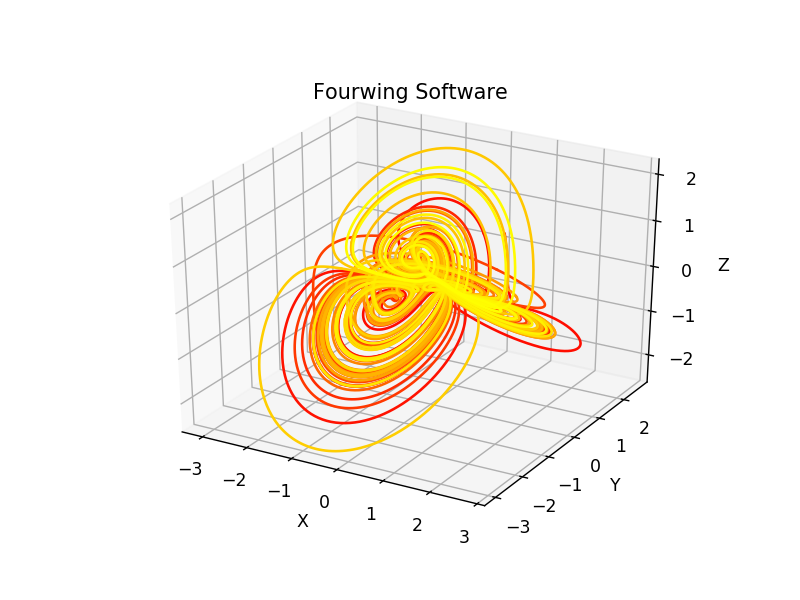

Time to plot points =  13.199840545654297  seconds


In [5]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotXSoft=[]
plotXSoft = [0 for i in range(iterationNew)]
plotYSoft=[]
plotYSoft = [0 for i in range(iterationNew)]
plotZSoft=[]
plotZSoft = [0 for i in range(iterationNew)]
for j in range(0,steps):
    colorSoft = plt.cm.autumn(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=colorSoft)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fourwing Software')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

### Hardware implementation:
##### Import Fourwing hardware:
The hardware was created using system generator and MATLAB. It was then exported to Vivado to generate a bitstream and hardware handoff that is utilised here.

In [6]:
from pynq import Overlay
ol = Overlay("fwheun.bit")
ol?
fourwing = ol.fwheun_0

##### Hardware driver:

In [7]:
def getNextCoord(x,y,z):
    fourwing.write(0x08, xBin[i-1])
    fourwing.write(0x04, yBin[i-1])
    fourwing.write(0x00, zBin[i-1])
    return fourwing.read(0x0C), fourwing.read(0x10), fourwing.read(0x14)

##### Create type conversion funtions:
Communication between software and hardware transfers 32 bits at a time; to allow for correct range and precision of expected results 8 integer bits were transferred and 24 fractional bits and is a signed number. When recieved, this binary formatting needs to be scaled back to float for plotting.

In [8]:
def binary_to_float(val):
    return float(val-(2**32)*int(str((val)>>(32-1))))/(2**24)

def float_to_binary(val):
    output = val*2**24
    if (output <0):
        output = int(int(output)+int(2**32))
    return int(output)

##### Generate results from hardware:

In [9]:
xBin = []
yBin = []
zBin = []

xBin = [0 for i in range(iterations)]
yBin = [0 for i in range(iterations)]
zBin = [0 for i in range(iterations)]

xBin[0] = (float_to_binary(1))
yBin[0] = (float_to_binary(1))
zBin[0] = (float_to_binary(1))


xvalshw = []
yvalshw = []
zvalshw = []

start = time.time()

for i in range(1,iterations):
    xBin[i], yBin[i], zBin[i] = getNextCoord(xBin[i-1],yBin[i-1],zBin[i-1])

elapsed_hardware_time = time.time() - start
print("Time to generate coordinates from hardware = ", elapsed_hardware_time, " seconds")

#Convert numbers to float from binary format
for i in range(iterations):
    xvalshw.append(binary_to_float(xBin[i]))
    yvalshw.append(binary_to_float(yBin[i]))
    zvalshw.append(binary_to_float(zBin[i]))
print("Total time including conversion to float format in software = " , time.time()-start, " seconds")

Time to generate coordinates from hardware =  52.062420129776  seconds
Total time including conversion to float format in software =  69.49979496002197  seconds


##### Plot hardware results:

<IPython.core.display.Javascript object>


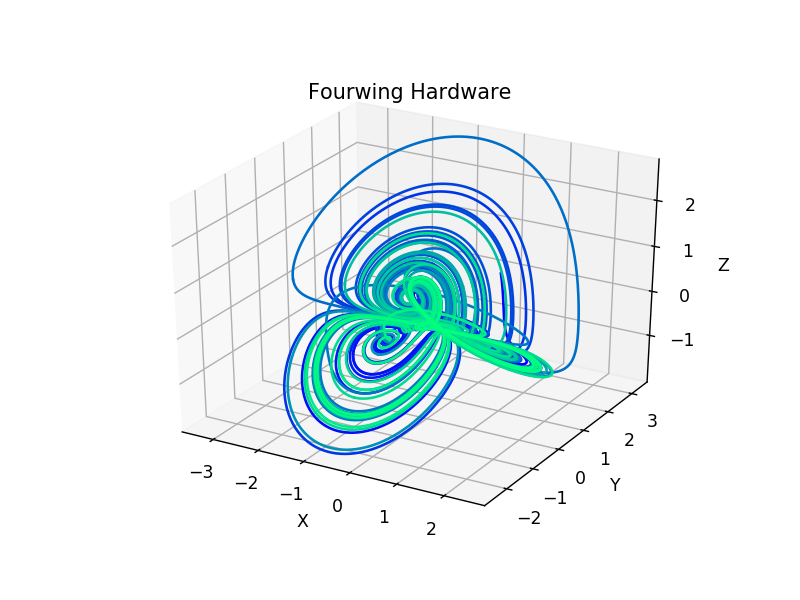

Time to plot points =  13.852933168411255  seconds


In [10]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotXHard=[]
plotXHard = [0 for i in range(iterationNew)]
plotYHard=[]
plotYHard = [0 for i in range(iterationNew)]
plotZHard=[]
plotZHard = [0 for i in range(iterationNew)]
for j in range(0,steps):
    colorHard = plt.cm.winter(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]
            plotYHard[i] = yvalshw[j*iterationNew + i-1]
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]
            plotYHard[i] = yvalshw[j*iterationNew + i]
            plotZHard[i] = zvalshw[j*iterationNew + i]
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fourwing Hardware')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

### Comparison of Two Methods:
##### Graphical Comparison:
It is clear from the graph produced that the two implementations create the same image. However it should be noted that the hardware implementation is not exactly the same due to the truncation of binary numbers compared to the floating point of the software implementation.

<IPython.core.display.Javascript object>


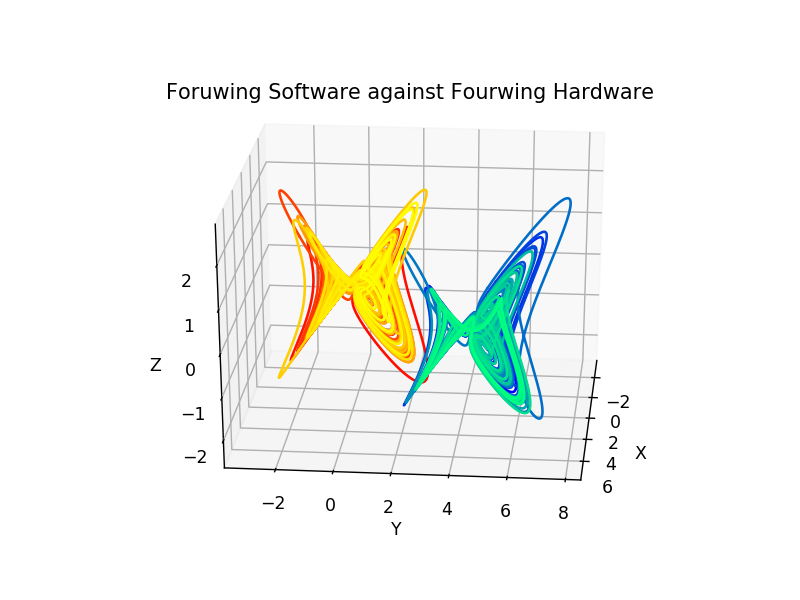

The average difference between software and hardware coordinates = 3.1569570490436747


In [11]:
start = time.time()

valDifferenceTotal = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xDiff=[]
xDiff = [0 for i in range(iterationNew)]

yDiff=[]
yDiff = [0 for i in range(iterationNew)]

zDiff=[]
zDiff = [0 for i in range(iterationNew)]

for j in range(0,steps):
    colorSoft = plt.cm.autumn(j/steps)
    colorHard = plt.cm.winter(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]+4.5
            plotYHard[i] = yvalshw[j*iterationNew + i-1]+4.5
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
            
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]+4.5
            plotYHard[i] = yvalshw[j*iterationNew + i]+4.5
            plotZHard[i] = zvalshw[j*iterationNew + i]
            
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
            
        valDifferenceTotal = valDifferenceTotal + abs((plotXHard[i] + plotYHard[i] + plotZHard[i] - 6) - 
                                                      (plotXSoft[i] + plotYSoft[i] + plotZSoft[i])) 
            
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=colorSoft)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Foruwing Software against Fourwing Hardware')
plt.show()

averageDifference = valDifferenceTotal / (iterations+1)
print("The average difference between software and hardware coordinates =", averageDifference)

##### Time Comparison:
It is apparent that the software is running at a significantly faster speed than the hardware. This is not ideal as the aim was to prove that the hardware can accelerate the speed.

In [12]:
print("Software duration =", elapsed_software_time, "seconds")
print("Hardware duration =", elapsed_hardware_time, "seconds")
print("The hardware implementation is", elapsed_software_time/elapsed_hardware_time, "times the speed of the software implementation")

Software duration = 19.333796501159668 seconds
Hardware duration = 52.062420129776 seconds
The hardware implementation is 0.37135800550505166 times the speed of the software implementation


### Discussion & Conclusions:
The difference in coordinates between software and hardware values is noticable. It has been calculated to be on average 3.15 units. This does not affect the overall shape of the attractor produced but it is apparent that there is adifference between the two. It should be noted that the difference will be accumulated with each iteration as each error is carried from the previous iteration.
<br><br>
A conclusion was drawn that the reason hardware currently takes longer is due to the large volume of data being passed between the PL and PS. This conclusion was drawn because the Vivado generated implementation can find the next coordinate in 0.15 microseconds whereas one loop of the software implementation takes on average 64 microseconds. Another reason this conclusion was drawn was because AXI-lite was used which requires a lot of overhead for each data transmission. In this scenario data is being transmitted 300000 times. iterations(inputs+outputs) = 300000(3+3) = 1800000 transmissions
<br><br>
Further work to improve these two problems would be to implement AXI-stream instead of AXI-lite. AXI-stream can provide bursts of data with less timing overheads than AXI-lite. AXI-stream also enables a larger bit width per input/output which could allow for a greater number of integer bits improving precision and reducing discrepancies between implementations.
<br><br>
In conclusion, the software implementation of generating a strange attractor using the heun method can be replicated in a parallel nature in hardware. The time taken to generate the next point using the heun method has been accelerated by using parallel architecture. However, this does not result in faster overall time due to the overhead of passing data between the PL and PS but has the potential to do so with further work.